In [ ]:
from pathlib import Path
import chess.pgn
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
DATADIR = Path.cwd().resolve() / "data"
if not DATADIR.exists():
    DATADIR.mkdir()

assert DATADIR.exists()

In [ ]:
LICHESS_DB_NAME = "lichess_db_standard_rated_2016-06.pgn"

LICHESS_ARCHIVE = DATADIR / f"{LICHESS_DB_NAME}.zst"
LICHESS_DB = DATADIR / LICHESS_DB_NAME
FINAL_GRAPH = DATADIR / "lichess_top1500_standard_rated_06_2016.gexf"

# нужно скачать отсюда
# https://database.lichess.org/standard/lichess_db_standard_rated_2016-06.pgn.zst
# ВАЖНО!!!!! Expect uncompressed files to be about 7.1 times larger.
assert LICHESS_ARCHIVE.exists()

if not LICHESS_DB.exists():
    ! zstd -d data/lichess_db_standard_rated_2016-06.pgn.zst -f
    print(f"Successfully made {LICHESS_DB.name}")
else:
    print(f"Found existing {LICHESS_DB.name}")

Found existing lichess_db_standard_rated_2016-06.pgn


In [4]:
def create_graph_from_pgn(pgn, max_games):

    G = nx.Graph()

    for i in tqdm(range(max_games), total=max_games):

        game = chess.pgn.read_game(pgn)
        if not game or i == max_games:
            break

        white = game.headers.get("White", "").strip()
        black = game.headers.get("Black", "").strip()

        if white and black and white != black:

            # Создаем ребро, либо увеличиваем его вес
            if G.has_edge(white, black):
                G[white][black]["weight"] += 1
            else:
                G.add_edge(white, black, weight=1)

            # Берем максимальный рейтинг обоих игроков за период
            G.nodes[white]["rating"] = (
                max(
                    [
                        int(G.nodes[white].get("rating", 0) or 0),
                        int(game.headers.get("WhiteElo", 0) or 0),
                    ]
                )
            )

            G.nodes[black]["rating"] = (
                max(
                    [
                        int(G.nodes[black].get("rating", 0) or 0),
                        int(game.headers.get("BlackElo", 0) or 0),
                    ]
                )
            )

    return G

In [5]:
with open(LICHESS_DB) as pgn:
    G = create_graph_from_pgn(pgn, 300000)

100%|██████████| 300000/300000 [07:09<00:00, 699.27it/s]


In [6]:
G.number_of_nodes(), G.number_of_edges()

(47486, 220514)

In [ ]:
top_players = sorted(
    G.nodes(data=True),
    key=lambda pair: pair[1]["rating"],
    reverse=True
)[:1500]  # Берем топ 1500 игроков по рейтингу

G = G.subgraph([player[0] for player in top_players]).copy()
G.remove_nodes_from(list(nx.isolates(G)))  # И удаляем тех, у кого нет ребер

In [8]:
G.number_of_nodes(), G.number_of_edges()

(1253, 4006)

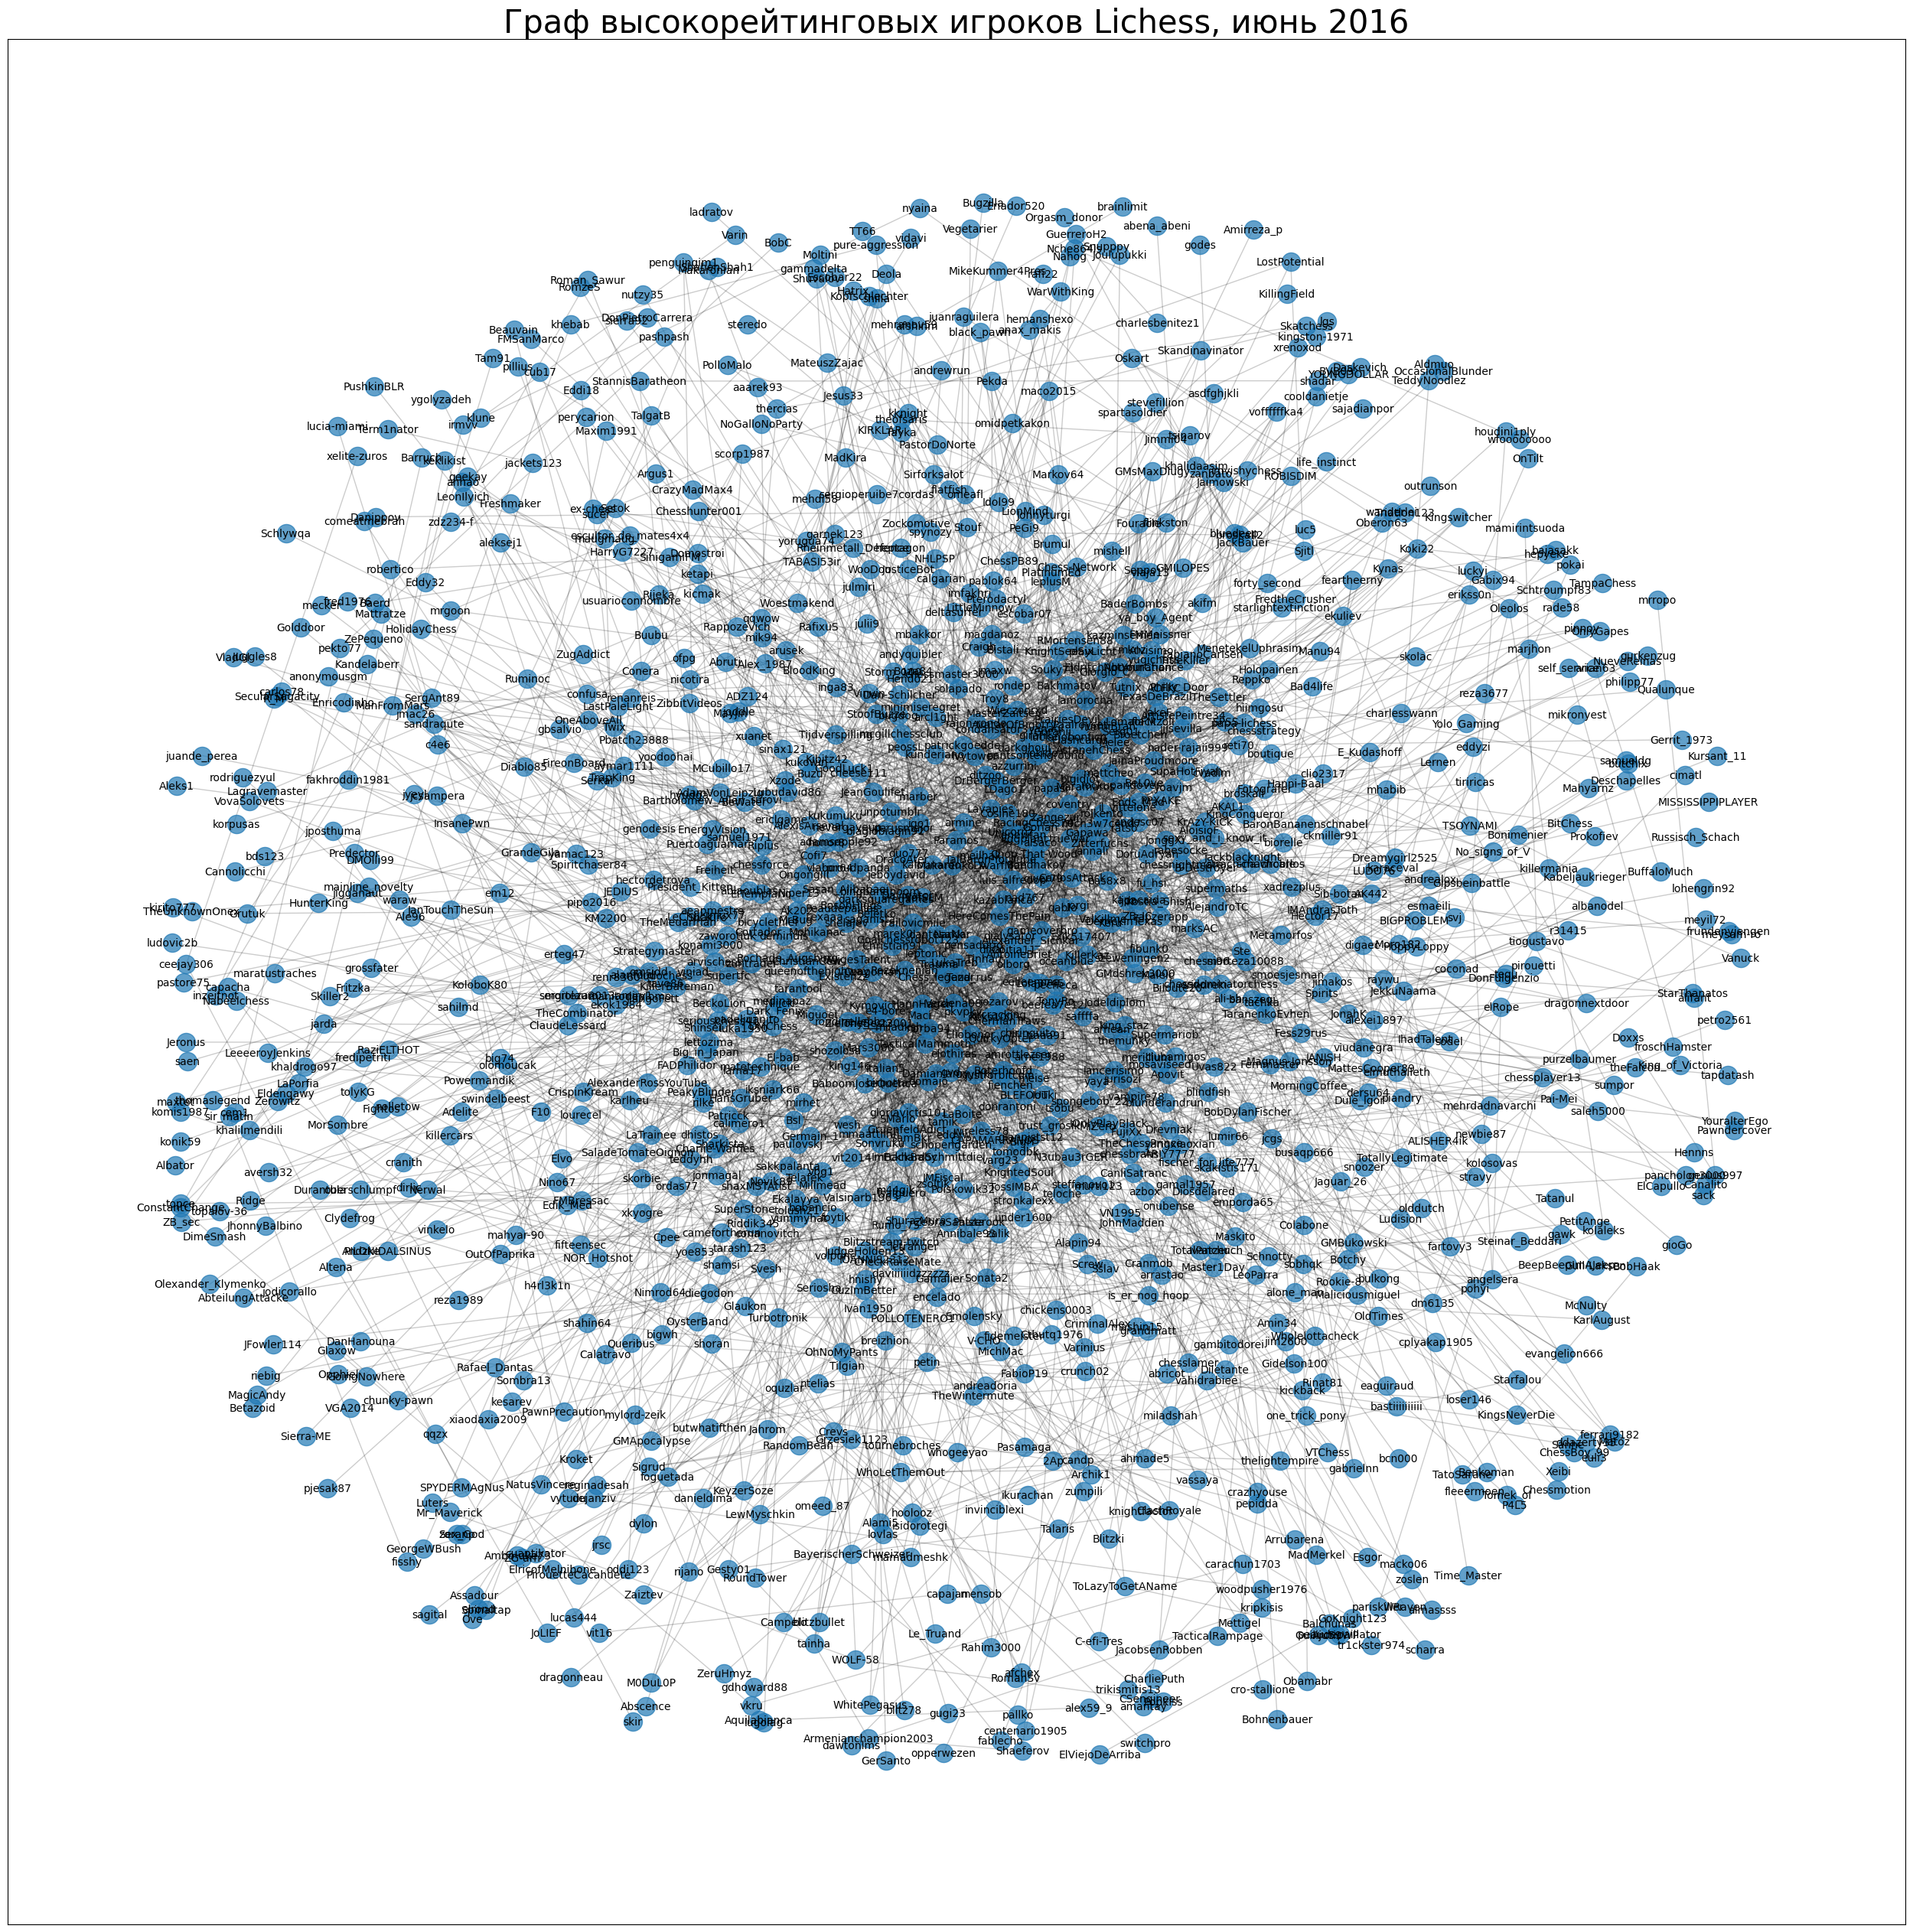

In [9]:
plt.figure(figsize=(32, 32))

pos = nx.spring_layout(G, k=0.3, iterations=50)

nx.draw_networkx_nodes (G, pos, alpha=0.7   )
nx.draw_networkx_edges (G, pos, alpha=0.2   )
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title(f"Граф высокорейтинговых игроков Lichess, июнь 2016", fontsize=30)

plt.show()

In [10]:
nx.write_gexf(G, FINAL_GRAPH, encoding="utf-8")